## Individual Campaign Finance Contributions from FEC Data (updated 10/29/2018)

The following Python code does some preliminary exploration of campaign finance data from the Federal Election Committee (FEC) website.  It requires that the following three files be downloaded and unzipped into the specified directories (relative to the notebook).  As can be seen, the top-level directory is fecYYMMDD where YYMMDD is the value of fdate and should be set to the date that the zip files are obtained from the FEC website.

[Candidate master for 2017-2018](https://www.fec.gov/files/bulk-downloads/2018/cn18.zip) - unzip and place cn.txt in directory fecYYMMDD/cm18/

[Committee master for 2017-2018](https://www.fec.gov/files/bulk-downloads/2018/cm18.zip) - unzip and place cm.txt in directory fecYYMMDD/cn18/

[Contributions by individuals for 2017-2018](https://www.fec.gov/files/bulk-downloads/2018/indiv18.zip) - unzip and place itcont.txt in directory fecYYMMDD/indiv18/

### Load all Individual Contributions and Merge Information from Committee and Candidate Tables.

The individual contribution table is very large.  It will be loaded into object ii and only reloaded if ii doesn't exist.  The following code will create ii if it doesn't exist and output the first row to show all available fields:


In [75]:
import pandas as pd
pd.set_option('display.width', 220)
pd.set_option('max_rows', 200)
#del ii #DEBUG delete to rerun
year = 2018
fdate = "181029"
try:
    ii
except NameError:
    yr = year % 100
    filepath = "fec"+fdate + "/indiv" + str(yr) + "/itcont.txt"
    hdr = pd.read_csv("https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv", skiprows=0)
    print("READING "+filepath)
    ii = pd.read_table(filepath, sep='|', header=None, names=hdr)
    print(ii.shape)
    hdr = pd.read_csv("https://www.fec.gov/data/advanced/files/bulk-downloads/data_dictionaries/cm_header_file.csv", skiprows=0)
    cm = pd.read_table("fec"+fdate + "/cm" + str(yr) + "/cm.txt", sep='|', header=None, names=hdr.columns)
    #cm = cm[['CMTE_ID','CMTE_NM','TRES_NM','CMTE_ST1','CMTE_ST2','CMTE_CITY','CMTE_ST','CMTE_ZIP','CMTE_DSGN','CMTE_TP',
    #         'CMTE_PTY_AFFILIATION','CMTE_FILING_FREQ','ORG_TP','CONNECTED_ORG_NM','CAND_ID']]
    cm = cm[['CMTE_ID','CMTE_NM','TRES_NM','CMTE_DSGN','CMTE_TP',
             'CMTE_PTY_AFFILIATION','CMTE_FILING_FREQ','ORG_TP','CONNECTED_ORG_NM','CAND_ID']]
    hdr = pd.read_csv("https://www.fec.gov/data/advanced/files/bulk-downloads/data_dictionaries/cn_header_file.csv", skiprows=0)
    cn = pd.read_table("fec"+fdate + "/cn" + str(yr) + "/cn.txt", sep='|', header=None, names=hdr.columns)
    #cn = cn[['CAND_ID','CAND_NAME','CAND_PTY_AFFILIATION','CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE',
    #         'CAND_OFFICE_DISTRICT','CAND_ICI','CAND_STATUS','CAND_PCC','CAND_ST1','CAND_ST2','CAND_CITY','CAND_ST','CAND_ZIP']]
    cn = cn[['CAND_ID','CAND_NAME','CAND_PTY_AFFILIATION','CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE',
             'CAND_OFFICE_DISTRICT','CAND_ICI','CAND_STATUS','CAND_PCC']]
    ii=ii.merge(cm, left_on='CMTE_ID', right_on='CMTE_ID')
    ii=ii.merge(cn, left_on='CAND_ID', right_on='CAND_ID', how='left')
    ii['TRANSACTION_DT'] = ii['TRANSACTION_DT'].fillna(0).astype(int)
    ii['TRANSACTION_DT'] = pd.to_datetime(ii['TRANSACTION_DT'],format='%m%d%Y',errors='coerce')
    ii.rename(columns={'TRANSACTION_DT':'DATE', 'TRANSACTION_AMT':'AMT', 'CAND_PTY_AFFILIATION':'PARTY'}, inplace=True)
    #ii['AMOUNT'] = ii['AMT'].apply(lambda x: '{:,}'.format(x))
print(ii.iloc[0,:])


CMTE_ID                                 C00629618
AMNDT_IND                                       N
RPT_TP                                        TER
TRANSACTION_PGI                                 P
IMAGE_NUM                      201701230300133512
TRANSACTION_TP                                15C
ENTITY_TP                                     IND
NAME                                PEREZ, JOHN A
CITY                                  LOS ANGELES
STATE                                          CA
ZIP_CODE                                    90017
EMPLOYER                                PRINCIPAL
OCCUPATION                 DOUBLE NICKEL ADVISORS
DATE                          2017-10-03 00:00:00
AMT                                            40
OTHER_ID                                H6CA34245
TRAN_ID                             SA01251735122
FILE_NUM                                  1141239
MEMO_CD                                       NaN
MEMO_TEXT                                     NaN


### Largest Individual Contributions Grouped by the Name, City, and State of the Contributor
The following code aggregates the individual contributions by the name, city, and state of the contributor to get an initial estimate of the total contributions made by each contributor.  This is only an initial estimate because, if a single contributor should vary or misspell any of these items, those contributions will be grouped separately.  For example, note that items 4, 21, 82, and 113 all appear to be for the same contributor, Richard Uihlein of Lake Forest, IL.  The names listed are UIHLEIN, RICHARD; UIHLEIN, RICHARD E.; UIHLEIN, RICHARD; UIHLEIN, RICHARD E. and  UIHLEIN, RICHARD E. MR.  Of these, only the first and third and the second and fourth appear to be the same.  However, the first (item 4) and third (item 68) differ in that the first state is IL and the second state is IN.  Then, the second (item 21) and fourth (item 82) differ because the latter item misspells the city as LAKE FORST.  Then, the last item (item 113) adds a "MR." to the end of the name for the first time.  In any event, the final total following the table shows that over $3.6 billion has already been contributed to federal candidates, PACs, and other committees in the 2017-2018 election cycle.


In [76]:
jj = ii.groupby(['NAME','CITY','STATE'])['AMT'].agg(['sum'])
jj = jj.reset_index(level=['NAME','CITY','STATE'])
jj.columns = ['NAME','CITY','STATE','AMT']
jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
jj = jj.sort_values(by='AMT',ascending=False)
jj.index = range(1,len(jj)+1)
print(jj[['NAME','CITY','STATE','AMOUNT']].head(200))
print('\nTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))


                                                  NAME               CITY STATE      AMOUNT
1                                    STEYER, THOMAS F.      SAN FRANCISCO    CA  41,576,481
2                                      ADELSON, MIRIAM          LAS VEGAS    NV  27,592,500
3                              AMERICAN ACTION NETWORK         WASHINGTON    DC  20,942,497
4                                     UIHLEIN, RICHARD        LAKE FOREST    IL  19,839,329
5                                          SCOTT, RICK        TALLAHASSEE    FL  19,388,022
6         UNITED BROTHERHOOD OF CARPENTERS AND JOINERS         WASHINGTON    DC  15,650,908
7                                     ADELSON, SHELDON          LAS VEGAS    NV  15,118,300
8                                        SOROS, GEORGE           NEW YORK    NY  14,160,714
9                     REPUBLICAN GOVERNORS ASSOCIATION         WASHINGTON    DC  13,176,173
10                                 ADELSON, SHELDON G.          LAS VEGAS    NV 

### Largest Individual Contributions Grouped by Committees Connected to Specific Candidates
The following code aggregates the individual contributions by the committee name, corresponding candidate name, and party of all committees connected to specific candidates.  As can be seen, "Team Ryan" is the top committee despite the fact its candidate, House leader Paul Ryan, is no longer running for reelection.  The second committee is "Rick Scott for Florida", connected to Rick Scott, Republican governor of Florida who is running against Democrat Senator Bill Nelson for his Senate seat.  As can be seen, the nearly \$32 million that it has raised is nearly three times as much as the nearly $11 raised by Nelson's chief committee, "Bill Nelson for US Senate".


In [77]:
jj = ii[pd.notnull(ii['CAND_ID'])]

jj = jj.groupby(['CMTE_NM','CAND_NAME','PARTY'])['AMT'].agg(['sum'])
jj = jj.reset_index(level=['CMTE_NM','CAND_NAME','PARTY'])
jj.columns = ['CMTE_NM','CAND_NAME','PARTY','AMT']
jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
jj = jj.sort_values(by='AMT',ascending=False)
jj.index = range(1,len(jj)+1)
print(jj[['CMTE_NM','CAND_NAME','PARTY','AMOUNT']].head(100))
print('\nTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))


                                          CMTE_NM                      CAND_NAME PARTY      AMOUNT
1                                       TEAM RYAN                  RYAN, PAUL D.   REP  53,458,491
2                          RICK SCOTT FOR FLORIDA                    SCOTT, RICK   REP  31,779,004
3                          MCCASKILL FOR MISSOURI              MCCASKILL, CLAIRE   DEM  28,070,115
4                        BOB CASEY FOR SENATE INC             CASEY, ROBERT P JR   DEM  15,737,269
5                 DOUG JONES FOR SENATE COMMITTEE                    JONES, DOUG   DEM  15,073,842
6                                  BETO FOR TEXAS        O'ROURKE, ROBERT (BETO)   DEM  14,250,105
7                             TED CRUZ FOR SENATE       CRUZ, RAFAEL EDWARD  TED   REP  13,881,579
8                           GILLIBRAND FOR SENATE  GILLIBRAND, KIRSTEN ELIZABETH   DEM  12,706,972
9                        TAMMY BALDWIN FOR SENATE                 BALDWIN, TAMMY   DEM  12,367,885
10        

### Largest Individual Contributions Grouped by Candidates
The following code aggregates the individual contributions by the candidate name and party of all candidates.  As can be seen, the first three candidates are the same as those listed in the prior section and their amounts are relatively close to those listed above, indicating that most of each candidates' fundraising is being done by one main committee.  The amounts are simply the sum of all committees supported with that candidate.  For example, the $57,763,577 listed for Paul Ryan equals the $53,458,491 listed for "Team Ryan" and the RYAN FOR CONGRESS, INC. $4,305,086 listed for "Ryan for Congress, Inc." in the prior section.


In [78]:
jj = ii.groupby(['CAND_NAME','PARTY'])['AMT'].agg(['sum'])
jj = jj.reset_index(level=['CAND_NAME','PARTY'])
jj.columns = ['CAND_NAME','PARTY','AMT']
jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
jj = jj.sort_values(by='AMT',ascending=False)
jj.index = range(1,len(jj)+1)
print(jj[['CAND_NAME','PARTY','AMOUNT']].head(100))
print('\nTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))


                         CAND_NAME PARTY      AMOUNT
1                    RYAN, PAUL D.   REP  57,763,577
2                      SCOTT, RICK   REP  35,511,899
3                MCCASKILL, CLAIRE   DEM  30,088,790
4         CRUZ, RAFAEL EDWARD  TED   REP  19,338,147
5               CASEY, ROBERT P JR   DEM  19,199,313
6                      JONES, DOUG   DEM  15,251,542
7                   BROWN, SHERROD   DEM  14,857,704
8                   BALDWIN, TAMMY   DEM  14,575,857
9          O'ROURKE, ROBERT (BETO)   DEM  14,250,105
10   GILLIBRAND, KIRSTEN ELIZABETH   DEM  13,519,271
11                 MCCARTHY, KEVIN   REP  12,472,774
12                     TESTER, JON   DEM  11,868,768
13                    TRONE, DAVID   DEM  11,714,114
14                    NELSON, BILL   DEM  11,416,886
15             OSSOFF, T. JONATHAN   DEM  11,054,480
16               FEINSTEIN, DIANNE   DEM   8,919,230
17                    CORNYN, JOHN   REP   8,779,009
18                MENENDEZ, ROBERT   DEM   7,9

### Largest Individual Contributions Grouped by Committees Not Connected to Specific Candidates
The following code aggregates the individual contributions by the committee names of all committees that are not connected to a specific candidate.  As can be seen, ActBlue has over four times the contributions of the next largest committee, the "Republican National Committee".  ActBlue is a liberal money-gathering platform written about in [this recent article](https://fivethirtyeight.com/features/how-actblue-is-trying-to-turn-small-donations-into-a-blue-wave/).


In [79]:
jj = ii[pd.isnull(ii['CAND_ID'])]
jj = jj.groupby(['CMTE_NM'])['AMT'].agg(['sum'])
jj = jj.reset_index(level=['CMTE_NM'])
jj.columns = ['CMTE_NM','AMT']
jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
jj = jj.sort_values(by='AMT',ascending=False)
jj.index = range(1,len(jj)+1)
print(jj[['CMTE_NM','AMOUNT']].head(100))
print('\nTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))


                                               CMTE_NM       AMOUNT
1                                              ACTBLUE  409,537,411
2                        REPUBLICAN NATIONAL COMMITTEE   99,168,560
3                        CONGRESSIONAL LEADERSHIP FUND   91,867,046
4                                                 DCCC   89,128,311
5                                                  SMP   77,585,814
6                               SENATE LEADERSHIP FUND   61,330,300
7                                                 DSCC   52,556,845
8              DNC SERVICES CORP./DEM. NAT'L COMMITTEE   50,003,481
9                     NEXTGEN CLIMATE ACTION COMMITTEE   42,232,597
10                                                NRSC   38,391,336
11                                  HOUSE MAJORITY PAC   36,812,603
12                          AMERICA FIRST ACTION, INC.   30,435,227
13                                       TRUMP VICTORY   29,967,696
14                                              

### Summary of Contributions by Specific Individuals
The following code summarizes the contributions given by any specific individual, given their name and, optionally, their city and/or state.  The contributions are grouped by the name, city, state, and party of the candidate.  If the contribution is to a committee not connected to a candidate, this last item will be "CMTE".  The results should be viewed as an estimate, at least until further investigation is done.  For example, seaching for "STEYER, THOMAS" did not reveal additional contributions for "STEYER, TOM".  Also, both have addresses in Redwood City and San Francisco, CA.  It's not clear that these are all for the same person though it is likely that all of the multi-million contribution is from the well-known billionaire.  This can be further investigated by looking at the specific contributions (in the next section) and perhaps even referencing the original filings for those contributions on the [FEC website](https://www.fec.gov/data/filings/?data_type=processed). 

In any case, the code below looks at the contributions for all of contributors previously shown to have made total contributions of $10 million or more.  Note that the search for "ADELSON, SHELDON" included the totals of both "ADELSON, SHELDON", "ADELSON, SHELDON G.", and "ADELSON, SHELDON G" in the third section above.  Also, the output reveals a number of misspellings and/or misentries such as for Lake Forest, IL by Richard Uihlein.


In [80]:
def getIndividualSum(name, city, state):
    jj = ii[ii['NAME'].str.contains(name, na=False)]
    if pd.notnull(city):
        jj = jj[jj['CITY'].str.contains(city, na=False)]
    if pd.notnull(state):
        jj = jj[jj['STATE'].str.contains(state, na=False)]
    #if pd.isnull(jj['CAND_ID']):
    #    jj['PARTY'] = jj['CMTE_PTY_AFFILIATION']
    #jj.loc[pd.isnull(jj['CAND_ID']),'PARTY'] = jj.loc[pd.isnull(jj['CAND_ID']),'CMTE_PTY_AFFILIATION']
    #jj.loc[pd.isnull(jj['CAND_ID']),'PARTY'] = jj.loc[pd.isnull(jj['CAND_ID']),'CMTE_NM']
    jj.loc[pd.isnull(jj['CAND_ID']),'PARTY'] = 'CMTE'
    #jj = jj[pd.notnull(jj['CAND_ID'])]
    jj['NAME'] = name
    kk = jj.groupby(['NAME','CITY','STATE','PARTY'])['AMT'].agg(['sum'])
    kk = kk.reset_index(level=['NAME','CITY','STATE','PARTY'])
    kk.columns = ['NAME','CITY','STATE','PARTY','AMT']
    kk['AMOUNT'] = kk['AMT'].apply(lambda x: '{:,}'.format(x))
    #kk.index = range(1,len(jj)+1)
    print(kk[['NAME','CITY','STATE','PARTY','AMOUNT']])
    print('TOTAL = ' + '{:,}'.format(sum(kk['AMT'])))

getIndividualSum('STEYER, THOMAS', '', '')
getIndividualSum('STEYER, TOM', '', '')
getIndividualSum('ADELSON, SHELDON', '', '')
getIndividualSum('ADELSON, MIRIAM', '', '')
getIndividualSum('UIHLEIN, RICHARD', '', '')
#getIndividualSum('UIHLEIN, ELIZABETH', '', '')
getIndividualSum('SCOTT, RICK', '', '')
getIndividualSum('SOROS, GEORGE', '', '')
getIndividualSum('TRONE, DAVID', '', '')
getIndividualSum('EYCHANER, FRED', '', '')
getIndividualSum('BEZOS, JEFF', '', '')
getIndividualSum('MELLON, TIMOTHY', '', '')


             NAME           CITY STATE PARTY      AMOUNT
0  STEYER, THOMAS   REDWOOD CITY    CA  CMTE      55,000
1  STEYER, THOMAS   REDWOOD CITY    CA   DEM      74,551
2  STEYER, THOMAS  SAN FRANCISCO    CA  CMTE  41,674,181
3  STEYER, THOMAS  SAN FRANCISCO    CA   DEM      41,500
TOTAL = 41,845,232
          NAME           CITY STATE PARTY   AMOUNT
0  STEYER, TOM        REDWOOD    CA   DEM    1,000
1  STEYER, TOM   REDWOOD CITY    CA  CMTE  340,100
2  STEYER, TOM   REDWOOD CITY    CA   DEM  172,100
3  STEYER, TOM  SAN FRANCISCO    CA  CMTE   25,000
4  STEYER, TOM  SAN FRANCISCO    CA   DEM    5,400
TOTAL = 543,600
               NAME       CITY STATE PARTY      AMOUNT
0  ADELSON, SHELDON  LAS VEGAS    GA   REP       2,700
1  ADELSON, SHELDON  LAS VEGAS    NV  CMTE  33,037,600
2  ADELSON, SHELDON  LAS VEGAS    NV   REP     176,600
TOTAL = 33,216,900
              NAME       CITY STATE PARTY      AMOUNT
0  ADELSON, MIRIAM  LAS VEGAS    GA   REP       2,700
1  ADELSON, MIRIAM  LAS VEG

### Summary of Contributions by Specific Committees
The following code summarizes the contributions given by any specific committee, given their name and, optionally, their city and/or state.  The contributions are grouped by the committee name, city, state, and party of the candidate.  As before, if the contribution is to a committee not connected to a candidate, this last item will be "CMTE".  Also, the code below looks at the contributions for all of committees previously shown to have made total contributions of $10 million or more.


In [81]:
getIndividualSum('AMERICAN ACTION NETWORK', None, '')
getIndividualSum('UNITED BROTHERHOOD OF CARPENTERS AND JOINERS', None, '')
getIndividualSum('REPUBLICAN GOVERNORS ASSOCIATION', None, '')
getIndividualSum('NATIONAL ASSOCIATION OF REALTO', None, '')


                      NAME        CITY STATE PARTY      AMOUNT
0  AMERICAN ACTION NETWORK  WASHINGTON    DC  CMTE  20,942,497
1  AMERICAN ACTION NETWORK  WASHONGTON    DC  CMTE      60,000
TOTAL = 21,002,497
                                           NAME        CITY STATE PARTY      AMOUNT
0  UNITED BROTHERHOOD OF CARPENTERS AND JOINERS  WASHINGTON    DC  CMTE  15,650,908
TOTAL = 15,650,908
                               NAME        CITY STATE PARTY      AMOUNT
0  REPUBLICAN GOVERNORS ASSOCIATION  WASHINGTON    DC  CMTE  13,176,173
TOTAL = 13,176,173
                             NAME     CITY STATE PARTY      AMOUNT
0  NATIONAL ASSOCIATION OF REALTO  CHICAGO    IL  CMTE  10,635,748
TOTAL = 10,635,748


### Top Individual Contributors for OpenSecrets.org on 10/29/18
The following code plots a horizontal bar chart of the top individual contributors according to [this page on OpenSecrets.org](https://web.archive.org/web/20181026032553/https://www.opensecrets.org/overview/topindivs.php) on 10/29/2018.  The top 21 contributors are copied into the code but only the top 17 are charted for readability.


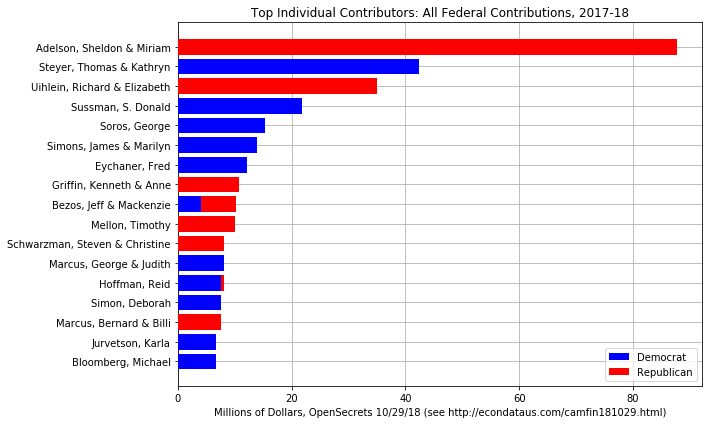

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import pandas as pd

ind = ['Adelson, Sheldon & Miriam', 'Steyer, Thomas & Kathryn', 'Uihlein, Richard & Elizabeth',
       'Sussman, S. Donald', 'Soros, George', 'Simons, James & Marilyn', 'Eychaner, Fred',
       'Griffin, Kenneth & Anne', 'Bezos, Jeff & Mackenzie', 'Mellon, Timothy',
       'Schwarzman, Steven & Christine','Marcus, George & Judith','Hoffman, Reid','Simon, Deborah',
       'Marcus, Bernard & Billi','Jurvetson, Karla','Bloomberg, Michael','Moskovitz, Dustin & Cari',
       'Skjodt, Paul & Cynthia','Beal, D. Andrew','Mercer, Robert & Diana']
tot = np.array([87.762600, 42.433582, 34.988529, 21.817700, 15.357486, 13.942810, 12.160800, 10.793100, 10.186170, 10.042100,
                8.213800, 8.085825, 8.049133, 7.646186, 7.586125, 6.683146, 6.661024, 5.330730, 5.116000, 5.062774, 4.693524])
per = np.array([0, 1, 0, 1, 1, 1, 1, 0, 0.4, 0, 0, 1, 0.95, 1, 0, 1, 1, 1, 1, 0, 0])
nn = 17 # only go up to Bloomberg for chart
ind = ind[0:nn]
tot = tot[0:nn]
per = per[0:nn]
dem = tot * per
rep = tot - dem
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
y_pos = np.arange(len(ind))
plt.grid(zorder=0)
ax.barh(y_pos, dem, align='center', color='blue', zorder=3)
ax.barh(y_pos, rep, align='center', color='red', zorder=3, left=dem)
ax.set_yticks(y_pos)
ax.set_yticklabels(ind)
ax.invert_yaxis()
ax.set_xlabel('Millions of Dollars, OpenSecrets 10/29/18 (see http://econdataus.com/camfin181029.html)')
ax.set_title('Top Individual Contributors: All Federal Contributions, 2017-18')
ax.legend(['Democrat','Republican'])
#plt.gcf().subplots_adjust()
plt.tight_layout()
plt.show()
fig.savefig('indcon181029.png')


### Top Individual Contributors for OpenSecrets.org on 10/31/18 (updated)
The following code plots a horizontal bar chart of the top individual contributors according to [this page on OpenSecrets.org](https://www.opensecrets.org/overview/topindivs.php) on 10/31/2018, just two days after the prior chart.  The top 26 contributors are copied into the code but only the top 17 are charted for readability.  As can be seen, the contributions have increased markedly for many of the contributors.  For example, the contributions from the Adelsons have increased from over \$87 million to over \$113 million and the contributions from Michael Bloomberg have increased from over \$6 million to over \$38 million.  [This page](https://www.opensecrets.org/outsidespending/donor_detail.php?cycle=2018&id=U0000000310&type=I&super=N&name=Adelson%2C+Sheldon+G.+%26+Miriam+O.) shows that the key new contributions from the Adelsons were \$25 million in contributions made on 9/12/18 to the Senate Leadership Fund.  [This  page](https://www.opensecrets.org/donor-lookup/results?name=Bloomberg%2C+Michael&order=desc&sort=D) shows that the key new contribution by Bloomberg was one for \$20 million made on 10/05/18 to the Senate Majority PAC.


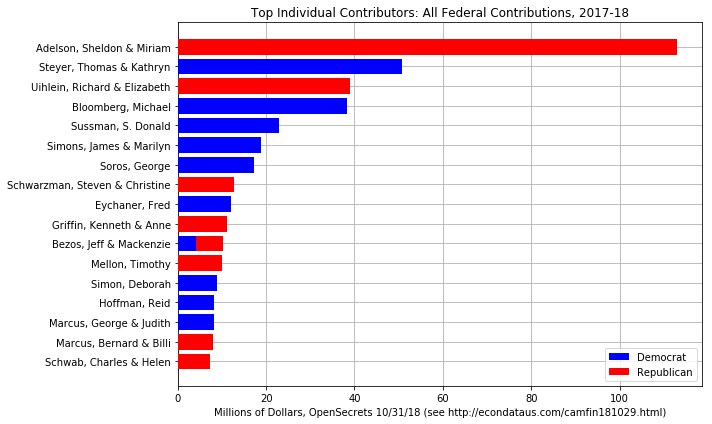

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import pandas as pd

ind = ['Adelson, Sheldon & Miriam','Steyer, Thomas & Kathryn','Uihlein, Richard & Elizabeth','Bloomberg, Michael',
       'Sussman, S. Donald','Simons, James & Marilyn','Soros, George','Schwarzman, Steven & Christine',
       'Eychaner, Fred','Griffin, Kenneth & Anne','Bezos, Jeff & Mackenzie','Mellon, Timothy',
       'Simon, Deborah','Hoffman, Reid','Marcus, George & Judith','Marcus, Bernard & Billi',
       'Schwab, Charles & Helen','Jurvetson, Karla','Skjodt, Paul & Cynthia','Cameron, Ronald & Nina',
       'Moskovitz, Dustin & Cari','Yass, Jeffrey & Janine','Beal, D. Andrew','Mercer, Robert & Diana',
       'Laufer, Henry & Marsha','Singer, Paul']
tot = np.array([113.036500, 50.773518, 39.095229, 38.229487, 22.876300, 18.918210, 17.365586, 12.814000, 12.173500, 11.070100,
                 10.186170, 10.055600,  8.956980,  8.118533,  8.110125,  7.926725,  7.296840,  7.085505,  6.621000,  6.543879,
                  6.365230,  6.119183,  6.085874,  5.993524,  5.680249,  5.163938])
per = np.array([0, 1, 0, 1,  1, 1, 1, 0,  1, 0, 0.4, 0,  1, 1, 1, 0,  0, 1, 1, 0,  1, 0, 0, 0,  1, 0])
nn = 17 # only go up to Bloomberg for chart
ind = ind[0:nn]
tot = tot[0:nn]
per = per[0:nn]
dem = tot * per
rep = tot - dem
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
y_pos = np.arange(len(ind))
plt.grid(zorder=0)
ax.barh(y_pos, dem, align='center', color='blue', zorder=3)
ax.barh(y_pos, rep, align='center', color='red', zorder=3, left=dem)
ax.set_yticks(y_pos)
ax.set_yticklabels(ind)
ax.invert_yaxis()
ax.set_xlabel('Millions of Dollars, OpenSecrets 10/31/18 (see http://econdataus.com/camfin181029.html)')
ax.set_title('Top Individual Contributors: All Federal Contributions, 2017-18')
ax.legend(['Democrat','Republican'])
#plt.gcf().subplots_adjust()
plt.tight_layout()
plt.show()
fig.savefig('indcon181031.png')


### List of All Contributions by Specific Individuals
The following code lists each contribution made by any specific individual, given their name and, optionally, their city and/or state.  The code first lists those contributions made to committees connected to a candidate and then lists those contributions made to committees not connected to a candidate.  Both lists are ordered by date and are generated by calling the function getIndividual2All.  The two calls below list all contributions by "STEYER, THOMAS" and "STEYER, TOM".  Both names show contributions from San Francisco, CA and Redwood City, CA which are about 22 miles apart.  The multi-million dollar contributions by STEYER, THOMAS F. in San Francisco suggest that these contributions are made by the [well-known billionaire](https://en.wikipedia.org/wiki/Tom_Steyer).  However, STEYER, TOM in Redwood City, CA can be seen to have made numerous contributions to DEMOCRACY ENGINE, INC., PAC.  Looking at the [this organization's most recent filing](http://docquery.fec.gov/pdf/895/201810099124435895/201810099124435895.pdf) shows that this contributor has "Fahr LLC" listed as their employer and "Advocacy & Philanthropy" listed as their occupation.  This suggests that these contributions were made by the same billionaire.


In [83]:
def getIndividual2Candidate(name, city, state):
    jj = ii[ii['NAME'].str.contains(name, na=False)]
    if pd.notnull(city): jj = jj[jj['CITY'].str.contains(city, na=False)]
    if pd.notnull(state): jj = jj[jj['STATE'].str.contains(state, na=False)]
    jj = jj[pd.notnull(jj['CAND_ID'])]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CAND_NAME','PARTY']]
    print(kk.head(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

def getIndividual2Committee(name, city, state):
    jj = ii[ii['NAME'].str.contains(name, na=False)]
    if pd.notnull(city): jj = jj[jj['CITY'].str.contains(city, na=False)]
    if pd.notnull(state): jj = jj[jj['STATE'].str.contains(state, na=False)]
    jj = jj[pd.isnull(jj['CAND_ID'])]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CMTE_NM']]
    print(kk.head(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

def getIndividual2All(name, city, state):
    getIndividual2Candidate(name, city, state)
    getIndividual2Committee(name, city, state)

getIndividual2All('STEYER, THOMAS', None, '')
getIndividual2All('STEYER, TOM', None, '')


                   NAME       DATE AMOUNT           CITY STATE                                        CAND_NAME PARTY
1        STEYER, THOMAS 2017-02-03  1,700  SAN FRANCISCO    CA                                  CANTWELL, MARIA   DEM
2        STEYER, THOMAS 2017-02-03  1,000  SAN FRANCISCO    CA                                  CANTWELL, MARIA   DEM
3   STEYER, THOMAS FAHR 2017-03-23  2,700  SAN FRANCISCO    CA                                     LOFGREN, ZOE   DEM
4   STEYER, THOMAS FAHR 2017-03-23  2,700  SAN FRANCISCO    CA                                     LOFGREN, ZOE   DEM
5        STEYER, THOMAS 2017-04-20  2,700  SAN FRANCISCO    CA                                BARRAGAN, NANETTE   DEM
6        STEYER, THOMAS 2017-09-21  2,700   REDWOOD CITY    CA                                     ROSEN, JACKY   DEM
7        STEYER, THOMAS 2017-09-21  2,700   REDWOOD CITY    CA                                     ROSEN, JACKY   DEM
8        STEYER, THOMAS 2017-09-21  2,700  SAN FRANCISCO

              NAME       DATE  AMOUNT           CITY STATE                CAND_NAME PARTY
1      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA       ROUDA, HARLEY E JR   DEM
2      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA           MORSE, JESSICA   DEM
3      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA      CAMPA-NAJJAR, AMMAR   DEM
4      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA        CISNEROS, GILBERT   DEM
5      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA             JANZ, ANDREW   DEM
6      STEYER, TOM 2018-03-27   2,700   REDWOOD CITY    CA        PORTER, KATHERINE   DEM
7      STEYER, TOM 2018-03-29   2,700   REDWOOD CITY    CA         MCCREADY, DANIEL   DEM
8      STEYER, TOM 2018-03-29   2,700   REDWOOD CITY    CA             BAER, LAUREN   DEM
9      STEYER, TOM 2018-03-29   2,700   REDWOOD CITY    CA    CRIST, CHARLIE JOSEPH   DEM
10     STEYER, TOM 2018-03-29   2,700   REDWOOD CITY    CA    CRIST, CHARLIE JOSEPH   DEM
11     STE

### List of All Contributions for Sheldon and Miriam Adelson
The two calls below list all contributions by "ADELSON, SHELDON" and "ADELSON, MIRIAM".  [Sheldon Adelson](https://en.wikipedia.org/wiki/Sheldon_Adelson) is the billionaire founder, chairman and chief executive officer of Las Vegas Sands Corporation and [Miriam Adelson](https://en.wikipedia.org/wiki/Miriam_Adelson) is his wife.  The lists show that the two contributed \$160,400, \$32,587,800  \$179,300, and \$33,037,600 for a total of \$65,965,100.  However, [a page on OpenSecrets.org](https://www.opensecrets.org/overview/topindivs.php) lists the total contributions to be \$87,762,600. [Another page](https://www.opensecrets.org/outsidespending/donor_detail.php?cycle=2018&id=U0000000310&type=I&super=N&name=Adelson%2C+Sheldon+G.+%26+Miriam+O.) shows the contribution details.  Comparing this to the details below shows that it contains \$22 million of contributions for September not contained in the FEC data.  That accounts for all but \$202,500 of the difference between \$87,762,600 and \$65,965,100.  The cause of that additional \$202,500 could be determined by comparing all of the contribution details.  In any case, following are the \$32 million of contributions shown by OpenSecrets for September, including the $22 million not in the FEC data:

| Contributor                       |       Amount |   Date   | Recipient
| :-------------------------------- | -----------: | :------: | :-----------------------------
| ADELSON, SHELDON G, LAS VEGAS, NV |  \$1,000,000 | 09/14/18 | Ending Spending Action Fund
| ADELSON, MIRIAM DR, LAS VEGAS, NV |  \$1,000,000 | 09/14/18 | Ending Spending Action Fund
| ADELSON, MIRIAM DR, LAS VEGAS, NV |  \$5,000,000 | 09/13/18 | America First Action (in FEC on 10/28)
| ADELSON, SHELDON G, LAS VEGAS, NV |  \$5,000,000 | 09/13/18 | America First Action (in FEC on 10/28)
| ADELSON, SHELDON, LAS VEGAS, NV   | \$10,000,000 | 09/12/18 | Congressional Leadership Fund
| ADELSON, MIRIAM, LAS VEGAS, NV    | \$10,000,000 | 09/12/18 | Congressional Leadership Fund

#### Problem in Using the Bulk Files
The above shows a problem with using the three bulk files listed at the beginning of this notebook.  Even though these bulk files were downloaded on October 29th, they still did not yet contain some contributions from September.  In fact, the \$10 million to "America First Action" just appeared in the update to the FEC bulk files on October 28th.  It is possible to see the other contributions by going to the [Filings page on  the FEC website](https://www.fec.gov/data/filings/?data_type=processed), typing type in and selecting the name of the committee or candidate to whom the contribution was made, and finding the filing that contains the contribution.

For example, select the first "Congressional Leadership Fund" entry for the committee (the second is for prior years), order the documents by date, search back in time until you find the document titled "OCTOBER QUARTERLY 2018 | Original", and open the [pdf version of the filing](http://docquery.fec.gov/pdf/932/201810159125090932/201810159125090932.pdf).  Searching for Adelson then shows the $10,000,000 contributions on page 17 of 396.  The same process can be followed to find the \$5,000,000 contributions on page 6 of the [October Quarterly filing for "America First Action"](http://docquery.fec.gov/pdf/149/201810159125429149/201810159125429149.pdf).  However, the same process does not seem able to find the \$1,000,000 contributions.

#### Problem in Using the Original Filings
A big problem with the original filings is that it's only possible to search them by the committee or candidate to whom the contribution is made.  There is apparently no way to automatic way to search by contributor.  As a result, some of the reports that use the filings seem to have omissions.  For example, the headline of a recent article is [Sheldon Adelson Breaks Spending Record on Midterm Elections, Surpassing $100M](https://www.rollcall.com/news/politics/sheldon-adelson-breaks-all-time-spending-records-on-the-midterm-elections-surpassing-100-million).  The article states:

> A new \$25 million donation puts the billionaire benefactors’ total spending toward helping Republicans hold on to both chambers of Congress at \$113 million, Bloomberg [reported](https://www.bloomberg.com/news/articles/2018-10-20/adelsons-add-25-million-to-their-midterm-campaign-spending). The donation was to the Senate Leadership Fund, a super PAC with ties to Senate Majority Leader [Mitch McConnell](https://www.rollcall.com/members?202&utm_source=memberLink?utm_source=memberLink).

The \$113 figure is about \$25 million more than the \$87,762,600 listed by [OpenSecrets.org](https://www.opensecrets.org/overview/topindivs.php).  In fact, the table above does not show a recent contribution to the Senate Leadership Fund.  Searching their filings, page 9 of the one titled ["OCTOBER MONTHLY 2018"](http://docquery.fec.gov/pdf/691/201810199125775691/201810199125775691.pdf) shows \$12.5 million contributions by each of Sheldon and Miriam Adelson on 9/12/2018.  This again suggests that there is no simple, automatic method for searching the filings by contributor.  The FEC site does contain a [CSV version of the filing](http://docquery.fec.gov/csv/945/1275945.csv) that contains the contribution but it may not be a simple matter to check and read this file.  Hence, it appears to be easy to miss contributions that are in the original filings but have not yet been added to the FEC bulk files.  As can be seen above, it appears that it can sometimes take over a month for all filings to be added.  This would seem to be a problem if rapid disclosure of contributions is desired.


In [84]:
getIndividual2All('ADELSON, MIRIAM', None, '')
getIndividual2All('ADELSON, SHELDON', None, '')
#getIndividual2All('ADELSON, SHELLEY', None, '')


                        NAME       DATE  AMOUNT       CITY STATE                   CAND_NAME PARTY
1        ADELSON, MIRIAM DR. 2017-03-10   2,700  LAS VEGAS    NV               ROYCE, ED MR.   REP
2        ADELSON, MIRIAM DR. 2017-03-10   2,700  LAS VEGAS    NV               ROYCE, ED MR.   REP
3        ADELSON, MIRIAM DR. 2017-03-27  10,400  LAS VEGAS    NV    CRUZ, RAFAEL EDWARD  TED   REP
4            ADELSON, MIRIAM 2017-03-31   2,700  LAS VEGAS    NV             BACON, DONALD J   REP
5            ADELSON, MIRIAM 2017-03-31   2,700  LAS VEGAS    NV             BACON, DONALD J   REP
6        ADELSON, MIRIAM DR. 2017-06-12  33,900  LAS VEGAS    NV               RYAN, PAUL D.   REP
7         ADELSON, MIRIAM DR 2017-06-16   2,700  LAS VEGAS    NV            FISCHER, DEBRA S   REP
8      ADELSON, MIRIAM DR DR 2017-06-16   2,700  LAS VEGAS    NV            FISCHER, DEBRA S   REP
9        ADELSON, MIRIAM DR. 2017-06-21   2,700  LAS VEGAS    NV                  ESTES, RON   REP
10        

                      NAME       DATE      AMOUNT       CITY STATE                                            CMTE_NM
1   ADELSON, SHELDON G MR. 2017-06-02       5,000  LAS VEGAS    NV  LAS VEGAS SANDS CORP. POLITICAL ACTION COMMITT...
2   ADELSON, SHELDON G MR. 2018-02-09       5,000  LAS VEGAS    NV  LAS VEGAS SANDS CORP. POLITICAL ACTION COMMITT...
3         ADELSON, SHELDON 2018-05-03  15,000,000  LAS VEGAS    NV                      CONGRESSIONAL LEADERSHIP FUND
4  ADELSON, SHELDON G. MR. 2018-06-01      33,900  LAS VEGAS    NV                      REPUBLICAN NATIONAL COMMITTEE
5         ADELSON, SHELDON 2018-06-25      43,900  LAS VEGAS    NV                         HELLER NEVADA VICTORY FUND
6      ADELSON, SHELDON G. 2018-06-30     371,500  LAS VEGAS    NV                                  PROTECT THE HOUSE
7      ADELSON, SHELDON G. 2018-07-26  12,500,000  LAS VEGAS    NV                             SENATE LEADERSHIP FUND
8      ADELSON, SHELDON G. 2018-09-07      78,300  LAS V

### List of All Contributions for Rick Scott
The call below lists all contributions by "SCOTT, RICK".  [Rick Scott](https://en.wikipedia.org/wiki/Rick_Scott) is the current governor of Florida who is running for the Senate against current Florida Senator [Bill Nelson](https://en.wikipedia.org/wiki/Bill_Nelson).  What is of special interest is that, not only is Rick Scott the federal candidate receiving the most funds after House Speaker Paul Ryan, he appears to be making most of the contributions.  Out of the total of \$35,511,899 in contributions, \$27,050,190 appears to be from Scott.  According to his [Wikipedia page](https://en.wikipedia.org/wiki/Rick_Scott), Scott's net worth stood at \$255 million as of August 2018.  That means that Scott has contributed over 10 percent of his net worth to his own campaign.


In [85]:
getIndividual2All('SCOTT, RICK', None, '')


                 NAME       DATE     AMOUNT         CITY STATE        CAND_NAME PARTY
1         SCOTT, RICK 2017-03-06      2,700       NAPLES    FL  GIANFORTE, GREG   REP
2         SCOTT, RICK 2018-02-05     50,613  TALLAHASSEE    FL      SCOTT, RICK   REP
3         SCOTT, RICK 2018-03-01        457  TALLAHASSEE    FL      SCOTT, RICK   REP
4         SCOTT, RICK 2018-03-31      5,132  TALLAHASSEE    FL      SCOTT, RICK   REP
5         SCOTT, RICK 2018-03-31      2,600  TALLAHASSEE    FL      SCOTT, RICK   REP
6         SCOTT, RICK 2018-03-31      7,500  TALLAHASSEE    FL      SCOTT, RICK   REP
7         SCOTT, RICK 2018-04-08      1,496  TALLAHASSEE    FL      SCOTT, RICK   REP
8         SCOTT, RICK 2018-04-09      2,417  TALLAHASSEE    FL      SCOTT, RICK   REP
9         SCOTT, RICK 2018-04-11      6,063  TALLAHASSEE    FL      SCOTT, RICK   REP
10        SCOTT, RICK 2018-04-12  2,500,000  TALLAHASSEE    FL      SCOTT, RICK   REP
11        SCOTT, RICK 2018-04-12      7,521  TALLAHASS

### For a Specified Committee, List All Individual Contributions
The following fuction getIndividual2Committee1 lists all contributions made to specific committees and sorted by date.  The two following calls list the contributions for the committees "Congressional Leadership Fund" and "Senate Leadership Fund".

The most recent contribution shown from Sheldon and Miriam Adelson to the "Senate Leadership Fund" is for \$12.5 million each on 7/26/2018.  As mentioned above, page 9 of that committee's filing titled ["OCTOBER MONTHLY 2018"](http://docquery.fec.gov/pdf/691/201810199125775691/201810199125775691.pdf) shows identical contributions being made on 9/12/2018.  The fact that the contributions are otherwise identical may be a reason why the more recent ones were missed by OpenSecrets.


In [86]:
def getIndividual2Committee1(cmte_nm):
    jj = ii[ii['CMTE_NM'].str.contains(cmte_nm, na=False)]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CMTE_NM']]
    kk['NAME'] = kk['NAME'].str[0:40]
    print(kk.tail(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

getIndividual2Committee1('CONGRESSIONAL LEADERSHIP')
getIndividual2Committee1('SENATE LEADERSHIP')


C:\Users\bdavi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bdavi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


                                         NAME       DATE     AMOUNT            CITY STATE                        CMTE_NM
225                       GOODNIGHT, JAMES H. 2018-05-31     99,999            CARY    NC  CONGRESSIONAL LEADERSHIP FUND
226                            DAY, ROBERT A. 2018-05-31     50,000     LOS ANGELES    CA  CONGRESSIONAL LEADERSHIP FUND
227                     MCCAFFERY, MICHAEL G. 2018-06-04     50,000    HILLSBOROUGH    CA  CONGRESSIONAL LEADERSHIP FUND
228                      HENDRICKS, DIANE MS. 2018-06-04    250,000          BELOIT    WI  CONGRESSIONAL LEADERSHIP FUND
229  PROPERTY CASUALTY INSURERS ASSOCIATION O 2018-06-04     75,000         CHICAGO    IL  CONGRESSIONAL LEADERSHIP FUND
230                          ZAGORIN, GREGORY 2018-06-10      1,500       ARLINGTON    VA  CONGRESSIONAL LEADERSHIP FUND
231                           AIMAN, SCOTT A. 2018-06-11      1,000       LANCASTER    OH  CONGRESSIONAL LEADERSHIP FUND
232          OCCIDENTAL PETROLEU

                                         NAME       DATE      AMOUNT               CITY STATE                 CMTE_NM
55                ALTRIA CLIENT SERVICES INC. 2017-10-10      25,000         WASHINGTON    DC  SENATE LEADERSHIP FUND
56                               GERVAIS, DON 2017-10-16         250        NEW ORLEANS    LA  SENATE LEADERSHIP FUND
57     LOVE'S TRAVEL STOPS AND COUNTRY STORES 2017-10-17      25,000      OKLAHOMA CITY    OK  SENATE LEADERSHIP FUND
58                                LLOYD, JOHN 2017-10-24       1,000         LONG BEACH    CA  SENATE LEADERSHIP FUND
59                        COLBURN, RICHARD W. 2017-10-31     200,000         NORTHBROOK    IL  SENATE LEADERSHIP FUND
60                       BUSCH, AUGUST A. III 2017-11-08      50,000       SAINT PETERS    MO  SENATE LEADERSHIP FUND
61                            FRANCO, ALAN I. 2017-11-08      25,000           METAIRIE    LA  SENATE LEADERSHIP FUND
62                             SMITH, MICHAEL 2017-11-13

### For a Specified Candidate, List All Individual Contributions
The following fuction getIndividual2Candidate1 lists all contributions made to a specific candidate and sorted by date.  The following call lists the contributions to Rick Scott.  As mentioned above, \$27,050,190 of the \$35,511,899 in contributions came from Scott himself but the output shows many of the other contributors.


In [87]:
def getIndividual2Candidate1(cand_name):
    jj = ii[ii['CAND_NAME'].str.contains(cand_name, na=False)]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CAND_NAME','PARTY']]
    print(kk.head(100))
    print(kk.tail(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

getIndividual2Candidate1('SCOTT, RICK')


                              NAME       DATE  AMOUNT             CITY STATE    CAND_NAME PARTY
1                      SCOTT, RICK 2018-02-05  50,613      TALLAHASSEE    FL  SCOTT, RICK   REP
2                      SCOTT, RICK 2018-03-01     457      TALLAHASSEE    FL  SCOTT, RICK   REP
3                      SCOTT, RICK 2018-03-31   5,132      TALLAHASSEE    FL  SCOTT, RICK   REP
4                      SCOTT, RICK 2018-03-31   7,500      TALLAHASSEE    FL  SCOTT, RICK   REP
5                      SCOTT, RICK 2018-03-31   2,600      TALLAHASSEE    FL  SCOTT, RICK   REP
6                 JORDAN, GERALD R 2018-04-04   2,700       PALM BEACH    FL  SCOTT, RICK   REP
7               HEUCHAN, BRECHT MR 2018-04-04   2,700      TALLAHASSEE    FL  SCOTT, RICK   REP
8      JORDAN, DARLENE L MRS OTHER 2018-04-04   2,700       PALM BEACH    FL  SCOTT, RICK   REP
9         HEUCHAN, BRECHT MR OTHER 2018-04-04   2,700      TALLAHASSEE    FL  SCOTT, RICK   REP
10           JORDAN, DARLENE L MRS 2018-

C:\Users\bdavi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### List All Individual Contributions above a Specific Amount
The following fuction getAllFromDate lists all contributions more than a specific amount and made after a specific date.  The following call lists all contributions of \$500,000 or more.


In [88]:
from datetime import datetime
#import pandas as pd
#pd.options.display.max_colwidth = 99

def getCandidateFromDate(date, minamt):
    #jj = ii[ii['NAME'].str.contains(name, na=False)]
    #if pd.notnull(city): jj = jj[jj['CITY'].str.contains(city, na=False)]
    #if pd.notnull(state): jj = jj[jj['STATE'].str.contains(state, na=False)]
    jj = ii[ii['AMT'] >= minamt]
    jj = jj[jj['DATE'] < datetime.now()]
    jj = jj[pd.notnull(jj['CAND_ID'])]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CAND_NAME','PARTY']]
    print(kk.tail(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

def getCommitteeFromDate(date, minamt):
    #jj = ii[ii['NAME'].str.contains(name, na=False)]
    #if pd.notnull(city): jj = jj[jj['CITY'].str.contains(city, na=False)]
    #if pd.notnull(state): jj = jj[jj['STATE'].str.contains(state, na=False)]
    jj = ii[ii['AMT'] >= minamt]
    jj = jj[jj['DATE'] < datetime.now()]
    jj = jj[pd.isnull(jj['CAND_ID'])]
    jj['AMOUNT'] = jj['AMT'].apply(lambda x: '{:,}'.format(x))
    jj = jj.sort_values(by='DATE',ascending=True)
    jj.index = range(1,len(jj)+1)
    kk = jj[['NAME','DATE','AMOUNT','CITY','STATE','CMTE_NM']]
    kk['NAME'] = kk['NAME'].str[0:35]
    kk['CMTE_NM'] = kk['CMTE_NM'].str[0:35]
    print(kk.tail(100))
    print('\nSUBTOTAL = ' + '{:,}'.format(sum(jj['AMT'])))

def getAllFromDate(date, minamt):
    getCandidateFromDate(date, minamt)
    getCommitteeFromDate(date, minamt)

getAllFromDate(None, 500000)


                             NAME       DATE     AMOUNT            CITY STATE              CAND_NAME PARTY
1   FLINN, GEORGE S DR JR S JR DR 2017-03-22  2,450,000         MEMPHIS    TN  FLINN, GEORGE S DR JR   REP
2               BARTOS, JEFFREY A 2017-06-21    500,000  MERION STATION    PA      BARTOS, JEFFREY A   REP
3                      MOODY, DAN 2017-09-30  2,803,120         ROSWELL    GA             MOODY, DAN   REP
4          BROWN, SHAUN DENISE MS 2017-09-30    674,157  VIRGINIA BEACH    VA    BROWN, SHAUN DENISE   DEM
5                    TRONE, DAVID 2017-10-01    573,939        BETHESDA    MD           TRONE, DAVID   DEM
6                    LYNCH, HOLLY 2017-10-13    500,000        NEW YORK    NY           LYNCH, HOLLY   DEM
7                    TRONE, DAVID 2017-11-13    500,000        BETHESDA    MD           TRONE, DAVID   DEM
8                    JACOBS, SARA 2017-12-22  1,000,000         DEL MAR    CA           JACOBS, SARA   DEM
9                    LYNCH, HOLLY 201

C:\Users\bdavi\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bdavi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### List All Contributions from the Koch Brothers
The following calls simply attempt to list all of the contributions connected with the Koch brothers, Charles and David.  As can be seen, \$3,308,900 is connected to Charles Koch, \$109,772 is connected to David Koch, and \$2,335,000 is connected to Koch Industries.  This adds up to \$5,753,672 a relatively small amount compared to the other top contributors.  However, this does not include any "dark money" which is not disclosed to the FEC for any of the contributors.


In [89]:
getIndividual2All('KOCH, CHARLES', None, 'KS')
getIndividual2All('KOCH, DAVID ', None, 'NY')
getIndividual2All('KOCH INDUSTRIES', None, '')
getIndividual2All('CHARLES G. KOCH', None, '')


                   NAME       DATE   AMOUNT     CITY STATE               CAND_NAME PARTY
1       KOCH, CHARLES G 2017-06-30    2,700  WICHITA    KS          HATCH, ORRIN G   REP
2       KOCH, CHARLES G 2017-06-30    2,700  WICHITA    KS          HATCH, ORRIN G   REP
3         KOCH, CHARLES 2017-11-27    2,700  WICHITA    KS  BLACKBURN, MARSHA MRS.   REP
4  KOCH, CHARLES G. MR. 2017-11-29  247,700  WICHITA    KS           RYAN, PAUL D.   REP
5      KOCH, CHARLES MR 2017-12-01    2,700  WICHITA    KS        BARRASSO, JOHN A   REP
6      KOCH, CHARLES MR 2017-12-01    2,700  WICHITA    KS    MORRISEY, PATRICK MR   REP
7       KOCH, CHARLES G 2018-02-26    2,700  WICHITA    KS          HATCH, ORRIN G   REP
8  KOCH, CHARLES G. MR. 2018-05-07    2,700  WICHITA    KS           RYAN, PAUL D.   REP

SUBTOTAL = 266,600
                 NAME       DATE   AMOUNT     CITY STATE                                            CMTE_NM
1       KOCH, CHARLES 2017-06-30    5,000  WICHITA    KS  KOCH INDUSTRI

Note: The Jupyter Notebook from which this post is generated can be found at http://econdataus.com/camfin181029.ipynb. It is based on bulk data downloaded from the FEC website on 10/29/2018. Links to additional Jupyter Notebooks can be found at http://econdataus.com/jupyter.html.
